<>:148: SyntaxWarning: invalid escape sequence '\l'
<>:149: SyntaxWarning: invalid escape sequence '\l'
<>:150: SyntaxWarning: invalid escape sequence '\l'
<>:148: SyntaxWarning: invalid escape sequence '\l'
<>:149: SyntaxWarning: invalid escape sequence '\l'
<>:150: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1496041/515950949.py:148: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log n$', fontsize=12)
/tmp/ipykernel_1496041/515950949.py:149: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log(\mathcal{E}(\hat{f})-\mathcal{E}(f^*))$', fontsize=12)
/tmp/ipykernel_1496041/515950949.py:150: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\log(\mathcal{E}(\hat{f})-\mathcal{E}(f^*))$ vs $\log n$ for $d=2, \sigma=0.2$', fontsize=14)


N=500 | RBF Excess Risk=0.00016,         Laplace Excess Risk=0.00083,               NTK Excess Risk=0.00072
N=550 | RBF Excess Risk=0.00012,         Laplace Excess Risk=0.00075,               NTK Excess Risk=0.00065
N=600 | RBF Excess Risk=0.00014,         Laplace Excess Risk=0.00074,               NTK Excess Risk=0.00064
N=650 | RBF Excess Risk=0.00016,         Laplace Excess Risk=0.00089,               NTK Excess Risk=0.00079
N=700 | RBF Excess Risk=0.00012,         Laplace Excess Risk=0.00064,               NTK Excess Risk=0.00055
N=750 | RBF Excess Risk=0.00008,         Laplace Excess Risk=0.00062,               NTK Excess Risk=0.00053
N=800 | RBF Excess Risk=0.00010,         Laplace Excess Risk=0.00060,               NTK Excess Risk=0.00052
N=850 | RBF Excess Risk=0.00007,         Laplace Excess Risk=0.00061,               NTK Excess Risk=0.00053
N=900 | RBF Excess Risk=0.00009,         Laplace Excess Risk=0.00060,               NTK Excess Risk=0.00052
N=950 | RBF Excess Risk=0.00

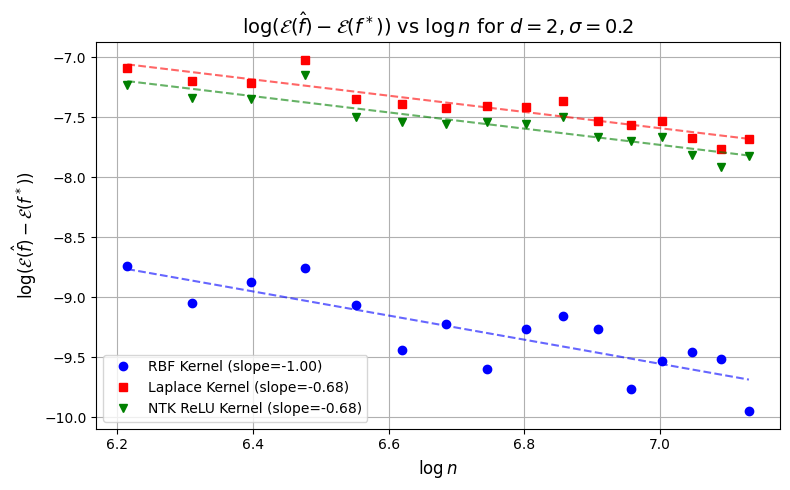

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cdist
from scipy.stats import linregress
import math
from numpy.linalg import solve, norm

def laplace_kernel(X, Y, a=1.0):
    dists = cdist(X, Y, metric='euclidean')
    return np.exp(-a * dists)

def rbf_kernel(X, Y, a=1.0):
    dists = cdist(X, Y, metric='euclidean')
    return np.exp(-a * np.square(dists)*0.1)

def ntk_relu(X, Y, beta=1.0):
    u = np.matmul(X, Y.T)*(1-1e-10)
    kern = ((2*u+beta**2)*(math.pi-np.arccos(u))+np.sqrt(1-u*u))/math.pi+beta**2
    return kern

def sample_data(N, d, sigma):
    X = np.random.randn(N, d)
    X /= np.linalg.norm(X, axis=1, keepdims=True) 
    Y = np.random.uniform(-sigma,sigma, size=N) #np.random.normal(0, sigma, size=N)
    return X, Y

def krr2_solution(K, y, lam):
    N = len(y)
    lam = max(lam, 1e-4)
    alpha = solve(K + N * lam * np.eye(N), y)
    return alpha

def find_lambda_star(K, y, radius, tol=1e-4, int_width=1e-10):
    N = len(y)
    max_iter = int(np.log(1e2/int_width-1)/np.log(2))+1
    alpha = krr2_solution(K, y, int_width)
    rkhs_norm = alpha @ K @ alpha
    if np.sqrt(rkhs_norm) <= radius:
        return int_width

    lam_low = int_width
    lam_high = 1e2

    for _ in range(max_iter):
        lam_mid = (lam_low + lam_high) / 2
        alpha = krr2_solution(K, y, lam_mid)
        rkhs_norm = alpha @ K @ alpha

        if abs(np.sqrt(rkhs_norm) - radius) < tol:
            return lam_mid
        elif np.sqrt(rkhs_norm) > radius:
            lam_low = lam_mid
        else:
            lam_high = lam_mid

    return int_width

def solve_krr1(K, y, radius):
    lambda_star = find_lambda_star(K, y, radius)
    alpha = krr2_solution(K, y, lambda_star)
#    print(len(y), lambda_star)
    return alpha

# 3. Estimate excess risk: MSE_model - MSE_true
def estimate_excess_risk(X_train, y_train, X_test, y_test, kernel_type, a, radius):
    if kernel_type == 'laplace_l2':
        K_train = laplace_kernel(X_train, X_train, a)
        K_test_train = laplace_kernel(X_test, X_train, a)
    if kernel_type == 'rbf':
        K_train = rbf_kernel(X_train, X_train, a)
        K_test_train = rbf_kernel(X_test, X_train, a)
    if kernel_type == 'ntk_relu':
        K_train = ntk_relu(X_train, X_train)
        K_test_train = ntk_relu(X_test, X_train)

    alpha = solve_krr1(K_train, y_train, radius)
    y_pred = K_test_train @ alpha

    mse_model = mean_squared_error(y_test, y_pred)
    mse_true = mean_squared_error(y_test, np.zeros(X_test.shape[0]))
    return mse_model - mse_true

# 4. Run experiment across multiple sample sizes
def run_experiment(N_list, d, sigma, test_size, a, radius):

    excess_risks_rbf = []
    excess_risks_laplace = []
    excess_risks_ntk_relu = []

    for N in N_list:
        risk_rbf = []
        risk_laplace = []
        risk_ntk_relu = []
        for num in range(10):
            X_train, y_train = sample_data(N, d, sigma)
            X_test, y_test = sample_data(test_size, d, sigma)
            
            risk_rbf.append(estimate_excess_risk(X_train, y_train, X_test, y_test, 'rbf', a, radius))
            risk_laplace.append(estimate_excess_risk(X_train, y_train, X_test, y_test, 'laplace_l2', a, radius))
            risk_ntk_relu.append(estimate_excess_risk(X_train, y_train, X_test, y_test, 'ntk_relu', a, radius))

        excess_risks_rbf.append(sum(risk_rbf)/10)
        excess_risks_laplace.append(sum(risk_laplace)/10)
        excess_risks_ntk_relu.append(sum(risk_ntk_relu)/10)

        print(f"N={N} | RBF Excess Risk={sum(risk_rbf)/10:.5f}, \
        Laplace Excess Risk={sum(risk_laplace)/10:.5f}, \
              NTK Excess Risk={sum(risk_ntk_relu)/10:.5f}")

    return excess_risks_rbf, excess_risks_laplace, excess_risks_ntk_relu

# 5. Plot results
def plot_excess_risks(N_list, rbf_risks, laplace_risks):
    plt.figure(figsize=(8, 5))
    plt.plot(N_list, rbf_risks, label='RBF Kernel', marker='o')
    plt.plot(N_list, laplace_risks, label='Laplace Kernel', marker='s')
    plt.xlabel('Training Set Size (N)')
    plt.ylabel('Excess Risk')
    plt.title('Excess Risk vs Training Size (Constrained KRR)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_logs(N_list, rbf_risks, laplace_risks, ntk_risks):
    # === Log-Log Transform ===
    log_N = np.log(N_list)
    log_rbf = np.log(rbf_risks)
    log_laplace = np.log(laplace_risks)
    log_ntk = np.log(ntk_risks)
    
    slope_rbf, intercept_rbf, *_ = linregress(log_N, log_rbf)
    slope_laplace, intercept_laplace, *_ = linregress(log_N, log_laplace)
    slope_ntk, intercept_ntk, *_ = linregress(log_N, log_ntk)
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(log_N, log_rbf, 'ob', label=f'RBF Kernel (slope={slope_rbf:.2f})')
    plt.plot(log_N, log_laplace, 'sr', label=f'Laplace Kernel (slope={slope_laplace:.2f})')
    plt.plot(log_N, log_ntk, 'vg', label=f'NTK ReLU Kernel (slope={slope_ntk:.2f})')
    
    plt.plot(log_N, intercept_rbf + slope_rbf * log_N, 'b--', alpha=0.6)
    plt.plot(log_N, intercept_laplace + slope_laplace * log_N, 'r--', alpha=0.6)
    plt.plot(log_N, intercept_ntk + slope_ntk * log_N, 'g--', alpha=0.6)
    
    plt.xlabel('$\log n$', fontsize=12)
    plt.ylabel('$\log(\mathcal{E}(\hat{f})-\mathcal{E}(f^*))$', fontsize=12)
    plt.title('$\log(\mathcal{E}(\hat{f})-\mathcal{E}(f^*))$ vs $\log n$ for $d=2, \sigma=0.2$', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cantor.pdf', dpi=400, bbox_inches='tight')
    plt.show()

N_list = range(500,1300,50) #range(1500,3000,50) # range(500,2000,200) 
d = 2
sigma = 0.2
gamma = 1.0  # inverse bandwidth
radius = 1.0

rbf_risks, laplace_risks, ntk_risks = run_experiment(N_list, d=d, sigma=sigma, test_size=10000, a=gamma, radius=radius)
plot_logs(N_list, rbf_risks, laplace_risks, ntk_risks)